In [ ]:
!pip install pyAgrum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 14.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# predict function
def predict(bn, data, var_target, show_progress=False):
    """
    This function is used to predict the posterior probability of a target variable from observations
    using a bayesian network model.

    Inputs:
    - =bn=: the predictive model given as a =pyAgrum.BayesNet= object
    - =data=: the data containing the observations used to predict the target variable
    as a =pandas.DataFrame= object
    - =var_target=: the name of the target variable as a =str= object

    Returns:
    - a =DataFrame= containing the posterior probability distribution of the target
    variable given each observation in =data=.
    """
    # Initialize the inference engine
    inf_bn = gum.LazyPropagation(bn)
    inf_bn.setTargets({var_target})
    nb_data = len(data)
    target_size = bn.variable(var_target).domainSize()
    target_dom = np.array([bn.variable(var_target).label(i)
                           for i in range(target_size)])
    data_records = data.to_dict("records")
    post_prob = np.zeros((nb_data, target_size))
    for i in range(nb_data):
        # Set the evidence
        inf_bn.setEvidence(data_records[i])
        # Run inference
        inf_bn.makeInference()
        # Compute posterior probability of target variable
        post_prob[i, :] = inf_bn.posterior(var_target).toarray()
        # Erase evidence
        inf_bn.eraseAllEvidence()
        if show_progress:
            sys.stdout.write("predict progress: {0:3.0%}\r".format(i/nb_data))

    post_prob_df = pd.DataFrame(post_prob,
                                index=data.index,
                                columns=bn.variable(var_target).labels())
    post_prob_df.columns.name = var_target
    return post_prob_df

In [ ]:
calls_dfd = {}
data_filename = f"calls_a2.csv.bz2"
print(f"Chargement du fichier {data_filename}")
calls_dfd[f"a2"] = pd.read_csv(
    data_filename,
    parse_dates=[f"date_a{k_bis}" for k_bis in range(1, 3)],
)

Chargement du fichier calls_a2.csv.bz2


# Exploration des données

In [ ]:
calls_dfd["a2"].head(5)

,lead_id,date_a1,weekday_a1,hour_a1,duration_a1,caller_id_a1,lead_answered_a1,date_a2,weekday_a2,hour_a2,duration_a2,caller_id_a2,lead_answered_a2,caller_has_changed_a2
0,fdeae76d3fef,2020-04-03 10:05:49,0Monday,h10,2,1e540d0ac463,no,2020-04-06 18:28:15,3Thursday,h18,2,08fcb33240a2,no,yes
1,73c015525161,2020-04-03 10:05:50,0Monday,h10,2,159e9c0a04f6,no,2020-04-06 18:28:15,3Thursday,h18,2,f986b4d3e9dd,no,yes
2,c718221df1be,2020-04-03 10:06:01,0Monday,h10,3,da44d3138279,no,2020-04-06 18:28:16,3Thursday,h18,3,b7824c80c481,no,yes
3,912712707f41,2020-04-03 10:07:54,0Monday,h10,2,1a3960780bb2,no,2020-04-06 18:28:16,3Thursday,h18,2,385232287fc4,no,yes
4,6b6797b56ae7,2020-04-03 10:08:05,0Monday,h10,3,1a3960780bb2,no,2020-04-06 18:28:16,3Thursday,h18,23,385232287fc4,yes,yes


In [ ]:
calls_dfd["a2"].describe(include="O")

,lead_id,weekday_a1,hour_a1,caller_id_a1,lead_answered_a1,weekday_a2,hour_a2,caller_id_a2,lead_answered_a2,caller_has_changed_a2
count,2824096,2824096,2824096,2824096,2824096,2824096,2824096,2824096,2824096,2824096
unique,2761053,5,9,900,1,5,9,987,2,2
top,40f09fe86afe,2Wednesday,h11,094fd601829a,no,3Thursday,h11,094fd601829a,no,yes
freq,3,620362,371260,56839,2824096,711154,387335,56846,2378305,2750376


In [ ]:
calls_dfd["a2"]["lead_answered_a2"].value_counts()

lead_answered_a2
no     2378305
yes     445791
Name: count, dtype: int64

In [ ]:
len(calls_dfd["a2"])

2824096

# Préparation des données

In [ ]:
var_cat = ["weekday_a1", "hour_a1", "weekday_a2", "hour_a2", "caller_has_changed_a2", "lead_answered_a2"]
for var in var_cat:
    calls_dfd["a2"][var] = calls_dfd["a2"][var].astype('category')

calls_dfd["a2"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2824096 entries, 0 to 2824095
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   lead_id                object        
 1   date_a1                datetime64[ns]
 2   weekday_a1             category      
 3   hour_a1                category      
 4   duration_a1            int64         
 5   caller_id_a1           object        
 6   lead_answered_a1       object        
 7   date_a2                datetime64[ns]
 8   weekday_a2             category      
 9   hour_a2                category      
 10  duration_a2            int64         
 11  caller_id_a2           object        
 12  lead_answered_a2       category      
 13  caller_has_changed_a2  category      
dtypes: category(6), datetime64[ns](2), int64(2), object(4)
memory usage: 188.5+ MB


# Préparation du modèle

In [ ]:
var_to_model = ["weekday_a1", "hour_a1", "weekday_a2", "hour_a2", "caller_has_changed_a2", "lead_answered_a2"]

X = calls_dfd["a2"][var_to_model]
y = calls_dfd["a2"]["lead_answered_a2"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_test = X_test.drop(columns=['lead_answered_a2'])
X_test

,weekday_a1,hour_a1,weekday_a2,hour_a2,caller_has_changed_a2
2802135,4Friday,h12,4Friday,h16,yes
1422470,0Monday,h12,0Monday,h16,yes
1899589,0Monday,h10,1Tuesday,h16,yes
2014809,2Wednesday,h12,0Monday,h11,yes
24274,0Monday,h14,4Friday,h10,yes
...,...,...,...,...,...
2596479,1Tuesday,h12,2Wednesday,h14,yes
853825,3Thursday,h16,3Thursday,h15,yes
1194729,3Thursday,h15,3Thursday,h10,yes
1915427,0Monday,h14,0Monday,h18,yes


In [ ]:
var_bn = {}
for var in var_to_model:
    nb_values = len(calls_dfd["a2"][var].cat.categories)
    var_bn[var] = gum.LabelizedVariable(var, var, nb_values)

In [ ]:
for var in var_bn:
    for i, modalite in enumerate(calls_dfd["a2"][var].cat.categories):
        var_bn[var].changeLabel(i, modalite)

In [ ]:
var_bn

{'weekday_a1': (pyAgrum.LabelizedVariable@0x57fea8233960) weekday_a1:Labelized({0Monday|1Tuesday|2Wednesday|3Thursday|4Friday}),
 'hour_a1': (pyAgrum.LabelizedVariable@0x57fea8dc90b0) hour_a1:Labelized({h10|h11|h12|h14|h15|h16|h17|h18|h19}),
 'weekday_a2': (pyAgrum.LabelizedVariable@0x57fea8dc8e00) weekday_a2:Labelized({0Monday|1Tuesday|2Wednesday|3Thursday|4Friday}),
 'hour_a2': (pyAgrum.LabelizedVariable@0x57fea8dc8bc0) hour_a2:Labelized({h10|h11|h12|h14|h15|h16|h17|h18|h19}),
 'caller_has_changed_a2': (pyAgrum.LabelizedVariable@0x57fea8dc8a40) caller_has_changed_a2:Labelized({no|yes}),
 'lead_answered_a2': (pyAgrum.LabelizedVariable@0x57fea8238630) lead_answered_a2:Labelized({no|yes})}

In [ ]:
# Entrainement
bn_custom = gum.BayesNet("modele custom")

for var in var_bn.values():
    bn_custom.add(var)

bn_custom.addArc("lead_answered_a2","weekday_a1")
bn_custom.addArc("lead_answered_a2","hour_a1")
bn_custom.addArc("weekday_a2", "caller_has_changed_a2")
bn_custom.addArc("hour_a2", "caller_has_changed_a2")
bn_custom.addArc("caller_has_changed_a2", "lead_answered_a2")

learner = gum.BNLearner(X_train)
learner.fitParameters(bn_custom)

(pyAgrum.BNLearner<double>@0x57fec3d47f20) Filename       : /tmp/tmpqav_d2jz.csv
Size           : (2541686,6)
Variables      : weekday_a1[5], hour_a1[9], weekday_a2[5], hour_a2[9], caller_has_changed_a2[2], lead_answered_a2[2]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -

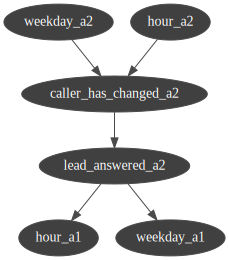

In [ ]:
gnb.showBN(bn_custom, size=10)

In [ ]:
bn_custom.cpt("lead_answered_a2")

(pyAgrum.Potential<double>@0x57fea8ddc260) 
      ||  lead_answered_a2 |
caller||no       |yes      |
------||---------|---------|
no    || 0.8452  | 0.1548  |
yes   || 0.8420  | 0.1580  |

In [ ]:
# Prédiction
pred_prob_custom = predict(
                          bn_custom,
                          data=X_test,
                          var_target="lead_answered_a2",
                          show_progress=True
                        )

pred_var_custom = pred_prob_custom.idxmax(axis=1).rename("pred")

In [ ]:
print(pred_prob_custom)

lead_answered_a2        no       yes
2802135           0.845608  0.154392
1422470           0.843133  0.156867
1899589           0.835112  0.164888
2014809           0.848425  0.151575
24274             0.837741  0.162259
...                    ...       ...
2596479           0.846303  0.153697
853825            0.845392  0.154608
1194729           0.842286  0.157714
1915427           0.837741  0.162259
203866            0.847512  0.152488

[282410 rows x 2 columns]


In [ ]:
print(pred_var_custom)

2802135    no
1422470    no
1899589    no
2014809    no
24274      no
           ..
2596479    no
853825     no
1194729    no
1915427    no
203866     no
Name: pred, Length: 282410, dtype: object


In [ ]:
(y_test == pred_var_custom).mean()

0.8427038702595517

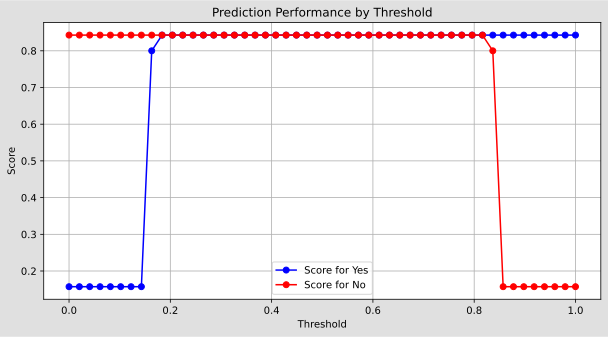

In [ ]:
thresholds = np.linspace(0, 1, 50)
scores_yes = []
scores_no = []

for thresh in thresholds:
    pred_binary_yes = pred_prob_custom['yes'].apply(lambda x: "yes" if x > thresh else "no")
    pred_binary_no = pred_prob_custom['no'].apply(lambda x: "no" if x > thresh else "yes")
    scores_yes.append((y_test == pred_binary_yes).mean())
    scores_no.append((y_test == pred_binary_no).mean())

plt.figure(figsize=(10, 5))
plt.plot(thresholds, scores_yes, 'bo-', label='Score for Yes')
plt.plot(thresholds, scores_no, 'ro-', label='Score for No')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Prediction Performance by Threshold')
plt.legend()
plt.grid(True)
plt.show()

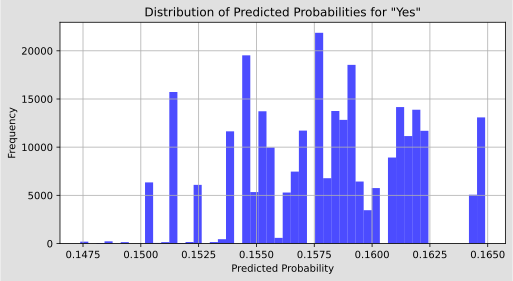

lead_answered_a2
no     237988
yes     44422
Name: count, dtype: int64


In [ ]:

# Visualiser les probabilités prédites
plt.figure(figsize=(8, 4))
plt.hist(pred_prob_custom['yes'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities for "Yes"')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Compter les instances de chaque classe dans y_test
print(y_test.value_counts())
